In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras import backend as K, metrics
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()
n = 2
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = False
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9947916666666665
 |>  150


In [5]:
n = 100
min_f = 3
max_f = 20
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
y_train = x_train

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0020833333333368
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0000000000000027
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9958333333333367
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.016666666666665
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9906250000000036
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.995833333333332
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0083333333333355
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0010416666666657
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.010416666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.990625000000001
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9979166666666672
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9968750000000024
 |>  150
 [DEBUG]

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0010416666666693
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0000000000000013
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9916666666666676
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.01979166666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.99375
 |>  150


In [6]:
x_train.shape

(283, 150, 1)

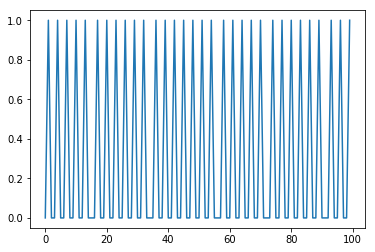

In [7]:
plt.plot(x_train[0,:100])

In [8]:
x_train.shape

(283, 150, 1)

In [9]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 150
input_shape

(150, 1)

In [10]:
output_shape

(150, 1)

In [11]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
# latent_dim = 1

In [12]:
k_reg = regularizers.l2(0.01) # 10e-5
# b_reg = regularizers.l1(0.01)
a_reg = regularizers.l1(0.01) # 10e-5

In [13]:
input_shape
# input_shape = (150,)
input_shape

(150, 1)

In [14]:
batch_size = 16
original_dim = 150
latent_dim = 2
intermediate_dim = 150
epsilon_std = 1.0

In [118]:
def sampling(args, latent_dim, epsilon_std):
    z_mean, z_log_var = args
    # epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [127]:
def encoder(latent_dim, input_shape, intermediate_dim = 150):
    encoder_input = Input(shape=input_shape, name='encoder_input-')
    y = encoder_input
    y = Reshape(input_shape[:1])(y) # Flatten() nees 3 dims
    h = Dense(intermediate_dim, activation='relu', name='encoder_h-')(y)
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'

    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, z_mean, z_log_var, encoder_input

def z_(latent_dim, epsilon_std):
    # sample z from a distribution defined by [input_mean, input_log_var]
    # input :: [z_mean, z_log_var]
    z_input = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
    sampling_ = lambda args: sampling(args, latent_dim, epsilon_std)
    z_output = Lambda(sampling_, name='z_sampler-')(z_input)
    # z_output = Lambda(sampling_, output_shape=(latent_dim,), name='z_sampler-')(z_input)
    z_model = Model(z_input, z_output, name='z_model-')
    return z_model

def decoder(latent_dim, input_shape, intermediate_dim = 150):
    z = Input(shape=(latent_dim,), name='decoder_input-')
    decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h-')
    h = decoder_h(z)
    decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean-')
    x_decoded_mean = decoder_mean(h)
    h = Reshape(input_shape)(x_decoded_mean)
    decoder_output = h
    model = Model(inputs=z, outputs=decoder_output, name='decoder_model-')
    return model

In [128]:
encoder_model, z_mean, z_log_var, encoder_input = encoder(latent_dim, input_shape)
z_model = z_(latent_dim, epsilon_std)
decoder_model = decoder(latent_dim, input_shape)

vae_input = Input(shape=input_shape)
# vae_input = Input(shape=(150,1))
vae_input = encoder_input # WHY ?
vae_output = decoder_model(z_model(encoder_model(vae_input)))
# vae_output = decoder_model(z)
vae = Model(vae_input, vae_output)
# vae = Model(encoder_input, decoder_model(z))
# vae = Model(encoder_input, decoder_output)
encoder_model.summary()
z_model.summary()
decoder_model.summary()
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
reshape_23 (Reshape)            (None, 150)          0           encoder_input-[0][0]             
__________________________________________________________________________________________________
encoder_h- (Dense)              (None, 150)          22650       reshape_23[0][0]                 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            302         encoder_h-[0][0]                 
__________________________________________________________________________________________________
z_log_var 

In [129]:
# encoder_input = Input(shape=input_shape)
# y = encoder_input
# y = Reshape(input_shape[:1])(y) # Flatten() nees 3 dims
# # y = Flatten()(y)

# y = Dense(150, activation='relu')(y)
# encoder_output = y
# encoder_model = Model(encoder_input, encoder_output)
# encoder_model.summary()

# vae_input = encoder_input # WHY ?
# y_input = Input(shape=(150,))
# y = Dense(150)(y_input)
# y = Reshape(input_shape)(y)
# y_model = Model(y_input, y)
# y_model.summary()
# # y_input = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
# # y = Reshape(input_shape)(y_input[0])
# # y = keras.layers.Concatenate()(y_input)
# # decoder2 = Model(y_input, y)
# # decoder2.summary()
# vae_ouput = Input(shape=input_shape)
# vae_ouput = y_model(encoder_model(vae_input))
# vae = Model(vae_input, vae_ouput)
# vae.summary()

In [130]:
# xent_loss = original_dim * keras.metrics.binary_crossentropy(vae_input, vae_output)
# xent_loss = keras.metrics.binary_crossentropy(vae_input, vae_output)
xent_loss = np.prod(input_shape) * keras.metrics.binary_crossentropy(vae_input, vae_output)
# kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# kl_loss = - 0.5 * K.sum(1 + 0 - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# kl_loss = K.sum(K.mean(z_mean) + K.exp(z_log_var), axis=-1)
kl_loss = K.mean(z_mean)


# vae_loss = K.mean(xent_loss)
vae_loss = K.mean(xent_loss + kl_loss)


vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  from ipykernel import kernelapp as app


In [131]:
# z_train = x_train
# x_train = x_train.reshape(x_train.shape[0],np.prod(x_train.shape[1:]))
x_train.shape

(133, 150, 1)

In [132]:
x_test = x_train[-10:]
x_train = x_train[:-10]

In [135]:
epochs = 100
m = 50
# , validation_data=(x_test, None)
history = vae.fit(x_train[:m], shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 50 samples, validate on 10 samples
Epoch 1/100
50/50 [==============================] - 0s 6ms/step - loss: 42.8674 - val_loss: 114.1409
Epoch 2/100
50/50 [==============================] - 0s 224us/step - loss: 40.9328 - val_loss: 111.6357
Epoch 3/100
50/50 [==============================] - 0s 211us/step - loss: 39.8036 - val_loss: 114.1370
Epoch 4/100
50/50 [==============================] - 0s 307us/step - loss: 38.3179 - val_loss: 109.7886
Epoch 5/100
50/50 [==============================] - 0s 339us/step - loss: 36.8357 - val_loss: 110.4101
Epoch 6/100
50/50 [==============================] - 0s 464us/step - loss: 35.4406 - val_loss: 110.0030
Epoch 7/100
50/50 [==============================] - 0s 374us/step - loss: 34.5759 - val_loss: 103.2946
Epoch 8/100
50/50 [==============================] - 0s 384us/step - loss: 34.4605 - val_loss: 105.6246
Epoch 9/100
50/50 [==============================] - 0s 502us/step - loss: 30.9941 - val_loss: 103.0030
Epoch 10/100
50/50 [==

50/50 [==============================] - 0s 280us/step - loss: -201.2993 - val_loss: -155.8358
Epoch 79/100
50/50 [==============================] - 0s 392us/step - loss: -198.6626 - val_loss: -207.5845
Epoch 80/100
50/50 [==============================] - 0s 366us/step - loss: -215.4698 - val_loss: -247.9974
Epoch 81/100
50/50 [==============================] - 0s 338us/step - loss: -217.1340 - val_loss: -176.2495
Epoch 82/100
50/50 [==============================] - 0s 345us/step - loss: -208.2813 - val_loss: -180.4925
Epoch 83/100
50/50 [==============================] - 0s 327us/step - loss: -212.5911 - val_loss: -259.3147
Epoch 84/100
50/50 [==============================] - 0s 367us/step - loss: -225.4047 - val_loss: -218.1371
Epoch 85/100
50/50 [==============================] - 0s 336us/step - loss: -236.1600 - val_loss: -280.4625
Epoch 86/100
50/50 [==============================] - 0s 342us/step - loss: -237.1466 - val_loss: -219.7910
Epoch 87/100
50/50 [=====================

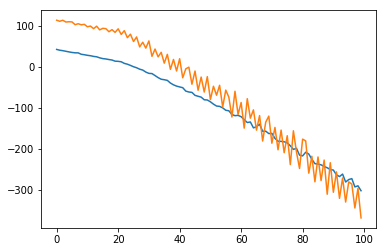

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
history.history.keys()

In [ ]:
# plot_model(vae, to_file='model.png')

In [ ]:
generator = decoder_model # decoder_model(z)
generator.summary()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [ ]:
plt.plot(x_train[0,:100,:])

In [ ]:
result.shape

In [ ]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)